In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image

In [2]:

from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent.parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 11, 'dt': 0.005, 'step_unit': 1000, 'temp_steps': 20, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 10, '_status': {}}

In [4]:
for job in project:
    print(job.sp)
    sim = job.fn("fixed-analysis/fire_temp-0.300.gsd")
    traj = gsd.hoomd.open(sim, 'rb')
    break

{'N': 32768, 'replica': 0, 'rho': 1.2, 'pot': 'KA_LJ'}


In [5]:
def vis_snap(snap: gsd.hoomd.Snapshot, ax: Optional[plt.Axes] = None, zoom=None, c=None, norm=None, s=0.1):

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    ax.clear()
    ax.set_aspect("equal")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xticks([])
    ax.set_yticks([])

    box = snap.configuration.box
    L = box[0]
    if zoom is not None:
        L /= zoom

    if c is None:
        ax.scatter(snap.particles.position[:, 0]/L, snap.particles.position[:, 1]/L, s=s)
    else:
        cmap = cm.jet
        if norm is None:
            norm = colors.Normalize(vmin=0.0, vmax=c.max())
        ax.scatter(snap.particles.position[:, 0]/L, snap.particles.position[:, 1]/L, s=s, c=c, cmap=cmap, norm=norm)
        
    
    return ax


# Naive calulation, ignoring Mermin-Wagner fluctuations

In [14]:
n = 10

In [15]:
snap = traj[0]
snap2 = traj[n]
box = freud.box.Box.from_box(snap.configuration.box)
diff = box.wrap(snap2.particles.position - snap.particles.position)
diff = np.linalg.norm(diff, axis=1)

<Axes: >

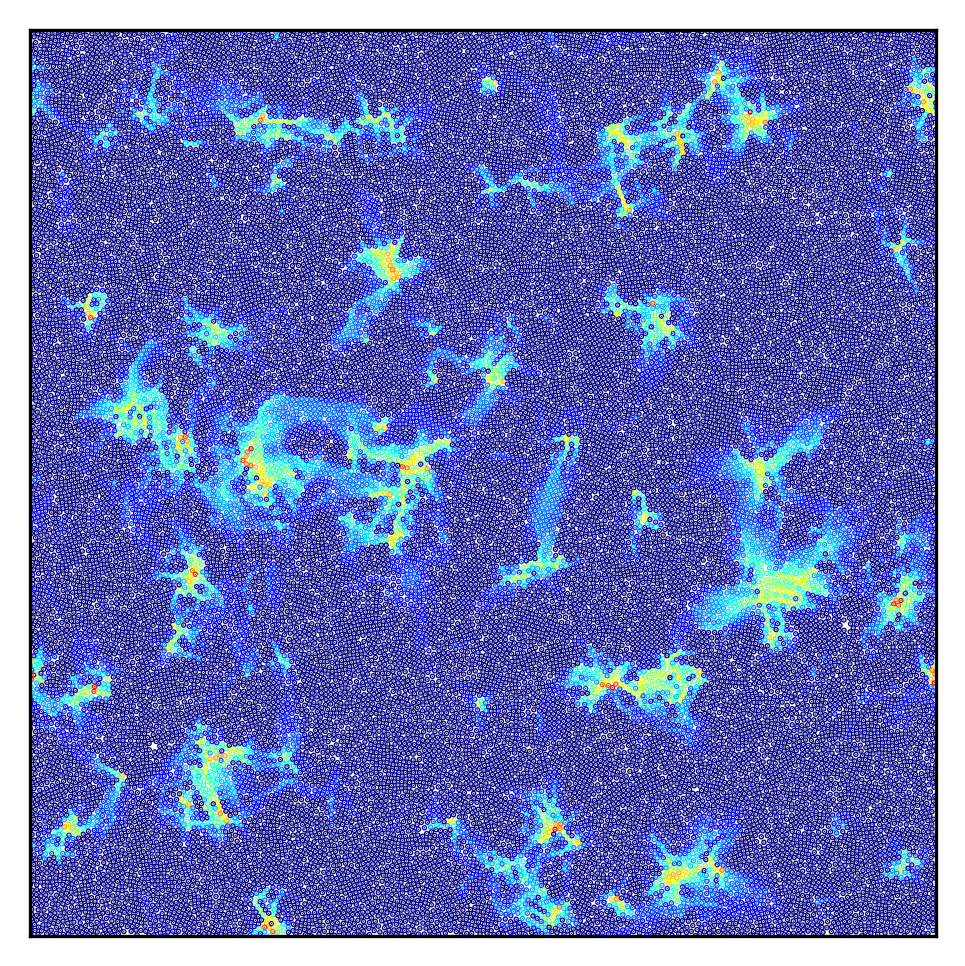

In [16]:
vis_snap(snap, zoom=2.0, c=diff, norm=colors.LogNorm(vmin=diff.mean(), vmax=diff.max()))

# Fix Mermin-Wagner fluctuations by using local neighborhood

In [17]:
snap = traj[0]
snap2 = traj[n]
box = freud.box.Box.from_box(snap.configuration.box)
diff = box.wrap(snap2.particles.position - snap.particles.position)
query = freud.AABBQuery.from_system(snap)
nlist = query.query(snap.particles.position, {"r_max": 2.0, "exclude_ii": True})
nlist = nlist.toNeighborList()

# take diff relative to neighbor average
neigh_diff = np.zeros_like(diff)
for i, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
    neighs = nlist.point_indices[seg:seg+nn]
    neigh_diff[i] = np.mean(diff[neighs], axis=0)

diff -= neigh_diff
diff = np.linalg.norm(diff, axis=1)

<Axes: >

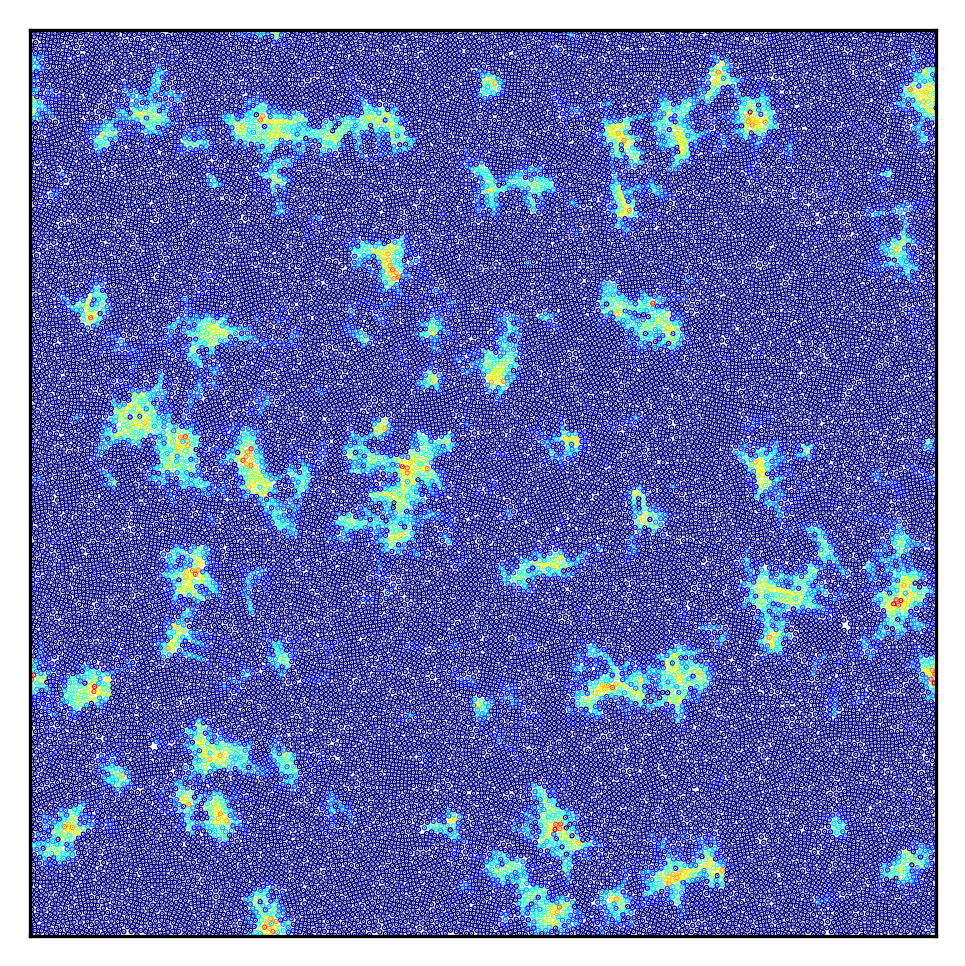

In [18]:
vis_snap(snap, zoom=2.0, c=diff, norm=colors.LogNorm(vmin=diff.mean(), vmax=diff.max()))